# **Data Visualization**
---

## Objective

- Answer business requirement 1:
    * The client wants to make sure that the animal images are distinguishable from one another and can be used to train a model.

## Inputs

- The folder `inputs/datasets/pets` containing the subfolders `train`, `test`, and `validation`
- The correctly labelled folders in each of these subfolders
- An adequate amount of preprocessed png images (size 128x128) in each labelled folder, showing a snapshot of a pet coming up to a bowl

## Outputs

- Image shape pickle file
- Mean image for each label
- Histograms showing the differences between the means
- Code that answers business requirement 1 and can be used to build an image montage on the Streamlit dashboard

---
## Preparation
### Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from matplotlib.image import imread
from tensorflow.keras.preprocessing import image
from PIL import Image
import random

sns.set_style("white")

### Set the correct working directory

In [2]:
# Check the current working directory
cwd = os.getcwd()
cwd

'd:\\Projekte\\Coding\\CodeInstitute\\PP5\\jupyter_notebooks'

In [3]:
# Move up to the project top directory
os.chdir(os.path.dirname(cwd))
cwd = os.getcwd()
cwd

'd:\\Projekte\\Coding\\CodeInstitute\\PP5'

### Set the main paths and constant variables

It was decided that the input shape of the images that the model will be trained on shall be (128, 128, 3).

In [4]:
dataset_name = "pets"
full_dataset_path = os.path.normpath(os.path.join(cwd, "inputs/datasets", dataset_name))
output_path = os.path.join(cwd, "outputs")
train_path = os.path.join(full_dataset_path, "train")
test_path = os.path.join(full_dataset_path, "test")
validation_path = os.path.join(full_dataset_path, "validation")

INPUT_SHAPE = (-1, 128, 128, 3)
joblib.dump(INPUT_SHAPE, f"{output_path}/input_shape.pkl")
LABELS = sorted(joblib.load(f"{output_path}/class_dict.pkl").values())

# The following line should show a list containing the subsets of the split dataset
os.listdir(full_dataset_path)

['test', 'train', 'validation']

### Util function to highlight errors and warnings

In [5]:
from colorama import Fore, Style


# Error notification style
def print_err(message):
    print(f"{Fore.RED}ERROR:{Style.RESET_ALL}\n{message}")


# Warning notification style
def print_warn(message):
    print(f"{Fore.YELLOW}WARNING:{Style.RESET_ALL}\n{message}")

### Util function to display a progress bar

In [6]:
def show_progress(label, list_len):
    width = 100
    for i in range(list_len):
        yield f'\r{label:<10}: {"#"*int(width if i == list_len-1 else i//(list_len/width)):<{width}}|| '

In [7]:
def set_ticks(ax):
    ax.set_xticks([])
    ax.set_yticks([])

In [8]:
from matplotlib.font_manager import FontProperties

font_top = FontProperties(
    weight="bold",
    size=20,
)
title_props_box = {
    "y": 0.87,
    "va": "bottom",
    "bbox": {"facecolor": "lightgreen", "alpha": 0.3, "edgecolor": "green"},
}
title_props = {
    "y": 0.85,
    "va": "bottom",
}

---
## Step 1
### Show image montage

Let's take a look at our dataset to make sure it is useable.

In [9]:
import itertools


def show_montage(nrows, ncols, labels):

    list_rows = range(0, nrows)
    list_cols = range(0, ncols)
    plot_idx = list(itertools.product(list_rows, list_cols))

    for label in labels:
        label_path = os.path.join(train_path, label)
        label_files = os.listdir(label_path)
        rnd_sample = random.sample(label_files, nrows * ncols)

        fig, axes = plt.subplots(
            nrows=nrows, ncols=ncols, figsize=(ncols * 4, nrows * 5)
        )
        for idx, img in enumerate(rnd_sample):
            img = np.asarray(Image.open(os.path.join(label_path, img))) / 255.0
            axes[plot_idx[idx][0], plot_idx[idx][1]].imshow(img)
            set_ticks(axes[plot_idx[idx][0], plot_idx[idx][1]])

        plt.suptitle(t=f"\n{label.upper()}:\n", fontproperties=font_top, **title_props)
        plt.axis("off")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

### Display the montage.

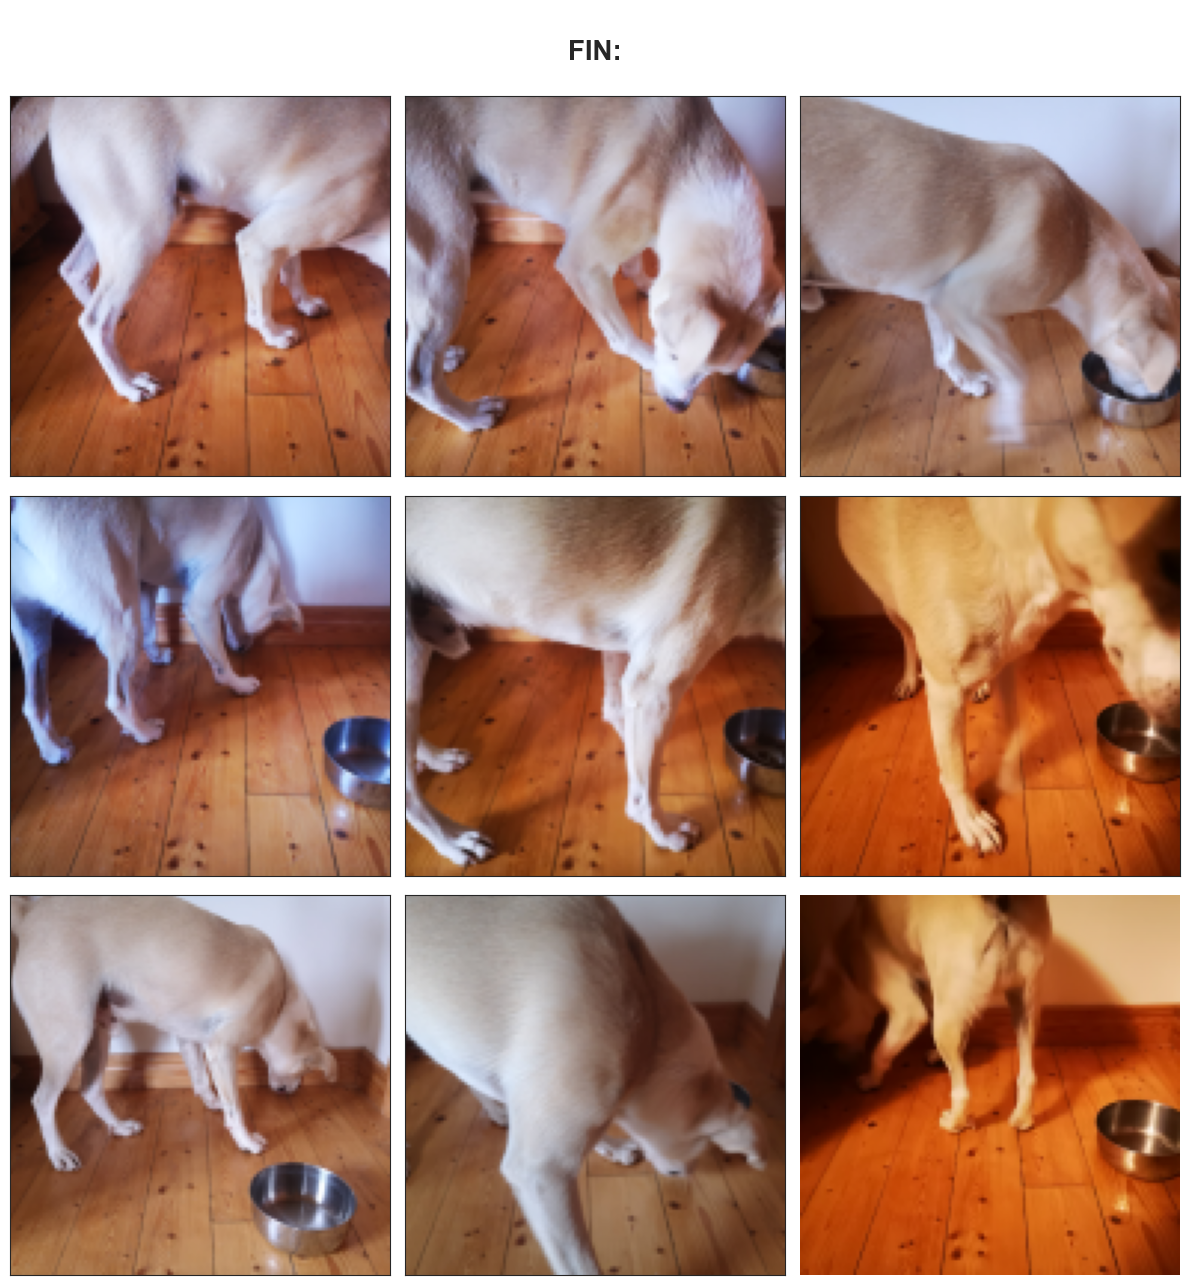

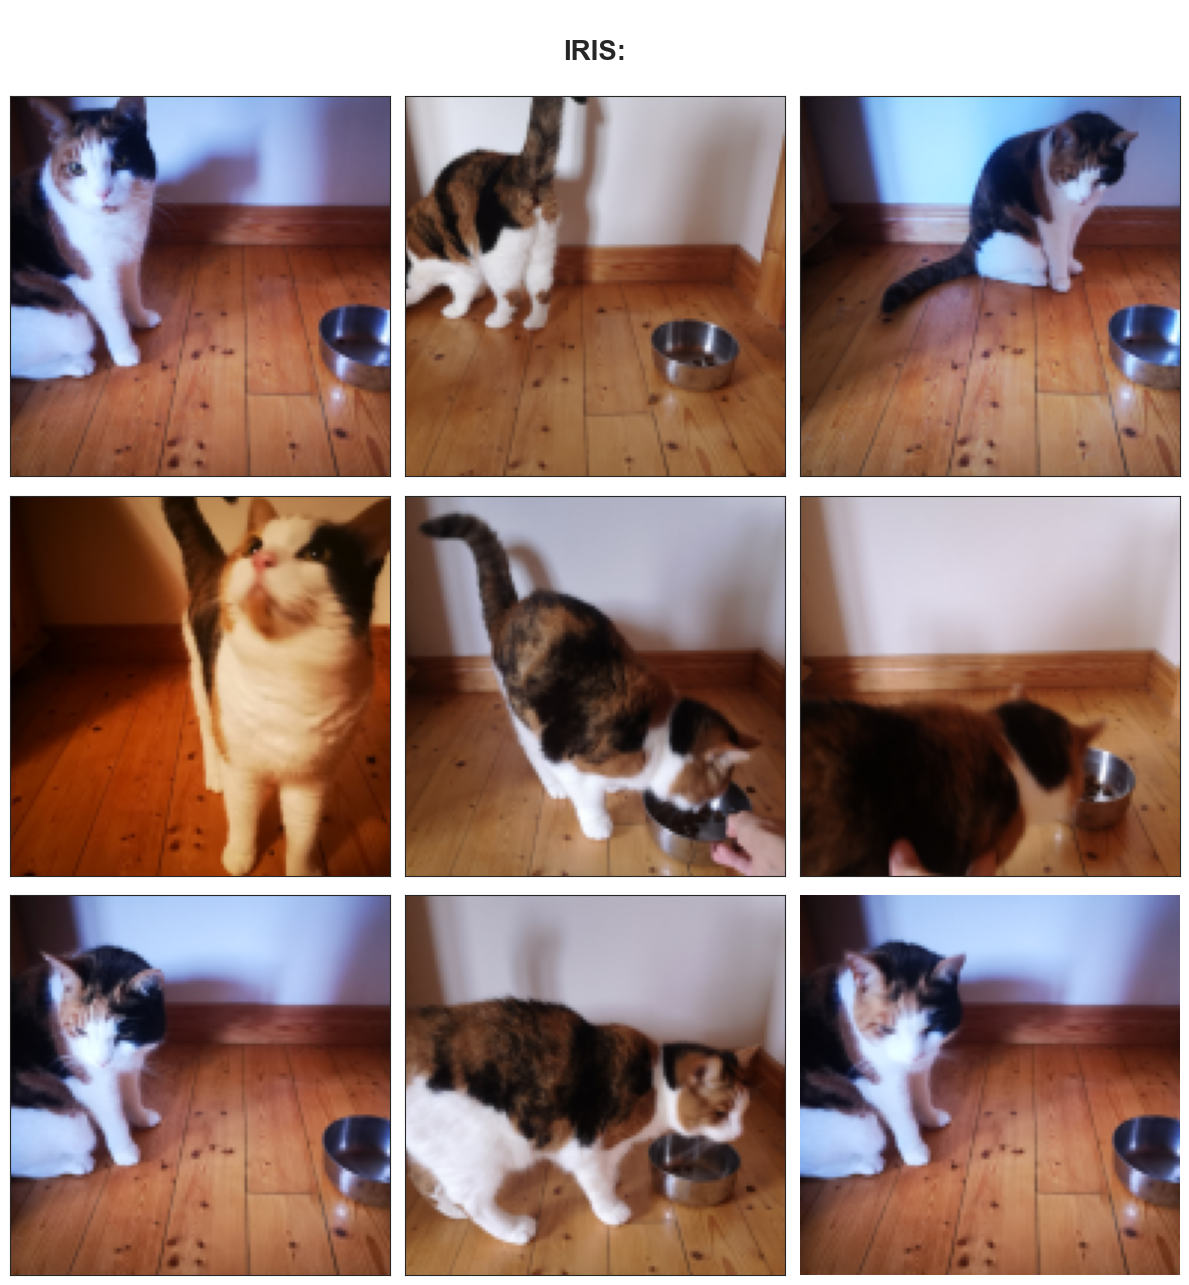

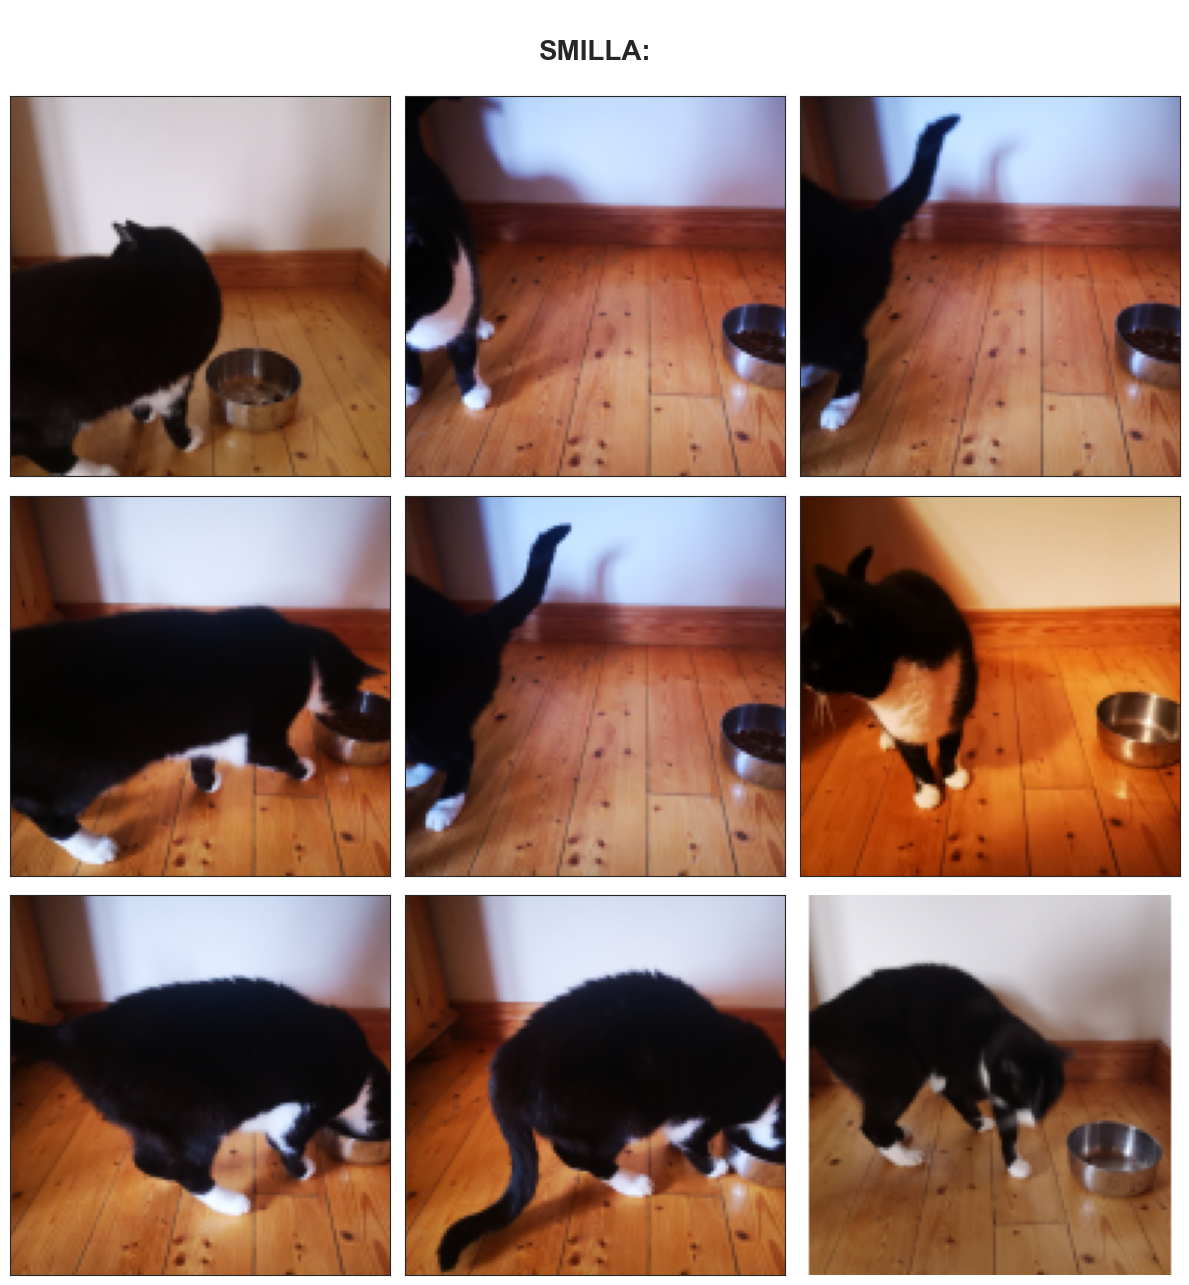

In [10]:
show_montage(3, 3, LABELS)

## Step 2
### Load image sample for visualization

Function to load all images into an array

In [11]:
# Load images from specified folder, resize them, save them as np array in X and save their labels in y
def save_images_in_array(path, shape, amount):

    dims = tuple(shape[1:3])
    X, y = np.array([], dtype="int"), np.array([], dtype="object")
    print(f"Loading from {path}:")

    for label in os.listdir(path):
        label_path = os.path.join(path, label)
        # Select a given amount of random images from the provided folder
        img_list = random.sample(
            os.listdir(label_path), min(amount, len(os.listdir(label_path)))
        )
        # Initialize progress bar generator
        progress_bar = show_progress(label, len(img_list))

        for img_name in img_list:
            img = image.load_img(os.path.join(path, label, img_name))
            if img.size != dims:
                img = img.resize(dims, resample=Image.LANCZOS)
            img_resized = image.img_to_array(img)
            if img_resized.max() > 1:
                img_resized = img_resized / 255.0
            X = np.append(X, img_resized).reshape(shape)
            y = np.append(y, label)
            print(next(progress_bar), end="")

        print(f"{len(img_list)} images loaded")

    # Shuffle the image set
    train_set = list(zip(y, X))
    random.shuffle(train_set)
    y_shuffled, X_shuffled = list(map(list, zip(*train_set)))
    X = np.array(X_shuffled, dtype="float32")
    y = np.array(y_shuffled, dtype="object")

    return X, y

In [12]:
# Load a sample of training images into an array
X_sample, y_sample = save_images_in_array(train_path, INPUT_SHAPE, amount=300)

Loading from d:\Projekte\Coding\CodeInstitute\PP5\inputs\datasets\pets\train:
fin       : ####################################################################################################|| 247 images loaded
iris      : ####################################################################################################|| 300 images loaded
smilla    : ####################################################################################################|| 268 images loaded


## Step 3
### Show average images for each label

First, we create a dictionary containing the mean images for each label.

In [13]:
# Create a dictionary with the mean images of all labels
import itertools
import functools


def get_means(X, y, labels):

    compound_dict = {"means": {}, "vars": {}}

    for label in labels:
        y = y.reshape(-1, 1, 1)
        bool_mask = np.any(y == label, axis=1).reshape(-1)
        arr = X[bool_mask]
        X_mean = np.mean(arr, axis=0)
        X_var = np.std(arr, axis=0)
        compound_dict["means"][label] = X_mean
        compound_dict["vars"][label] = X_var

    return compound_dict

In [14]:
compound_dict = get_means(X_sample, y_sample, LABELS)

Then we display the mean image for each label.

In [15]:
def calc_figure(amount):
    """Util function to calculate figure size depending on label amount

    Args:
        labels (list): List with all label names

    Returns:
        int: Amount of columns
        int: Amount of rows
        list: Coordinates for all label mean images
    """

    if (amount % 3 == 0 and amount % 2 == 0 and amount % 4 != 0) or (
        amount % 3 == 0 and amount <= 6
    ):
        ncols = 3
    elif amount == 2:
        ncols = 2
    else:
        ncols = max(min(2, amount + (amount % 3)), 4)

    nrows = max(1, (1 if amount % ncols != 0 else 0) + amount // ncols)

    if amount - ncols == 1 or amount - ncols * (nrows - 1) == 1:
        ncols = 3
        nrows = max(1, (1 if amount % ncols != 0 else 0) + amount // ncols)

    coords = list(itertools.product(range(nrows), range(ncols)))[:amount]

    return ncols, nrows, coords


def show_means(img_dict, img_type, labels):
    """Display the mean image for each label in a grid

    Args:
        img_dict (dict): Dictionary with mean or variance images as numpy arrays
        labels (list): list with all label names
    """

    ncols, nrows, coords = calc_figure(len(labels))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5))
    # Hide the axes of unused plots
    for ax in axes:
        if nrows == 1:
            ax.set_axis_off()
        else:
            for plot in ax:
                plot.set_axis_off()

    for idx, coord in enumerate(coords):
        if nrows > 1:
            axes[coord[0]][coord[1]].set_title(
                f"{img_type} image for label {labels[idx]}", fontweight="bold"
            )
            axes[coord[0]][coord[1]].imshow(img_dict[labels[idx]])
            set_ticks(axes[coord[0]][coord[1]])
        else:
            axes[idx].set_title(
                f"{img_type} image for label {labels[idx]}", fontweight="bold"
            )
            axes[idx].imshow(img_dict[labels[idx]])
            set_ticks(axes[idx])

    plt.savefig(
        f"{output_path}/{img_type.lower()}_images_grid.png",
        bbox_inches="tight",
        dpi=150,
    )
    plt.show()

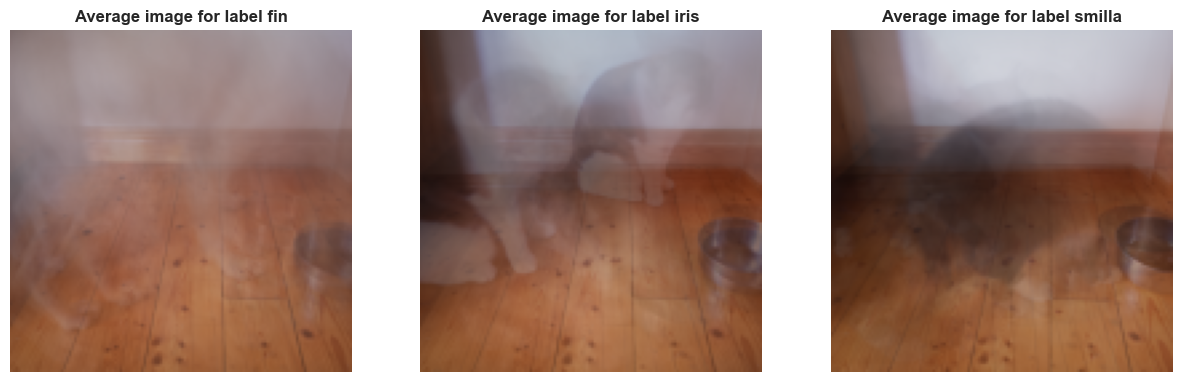

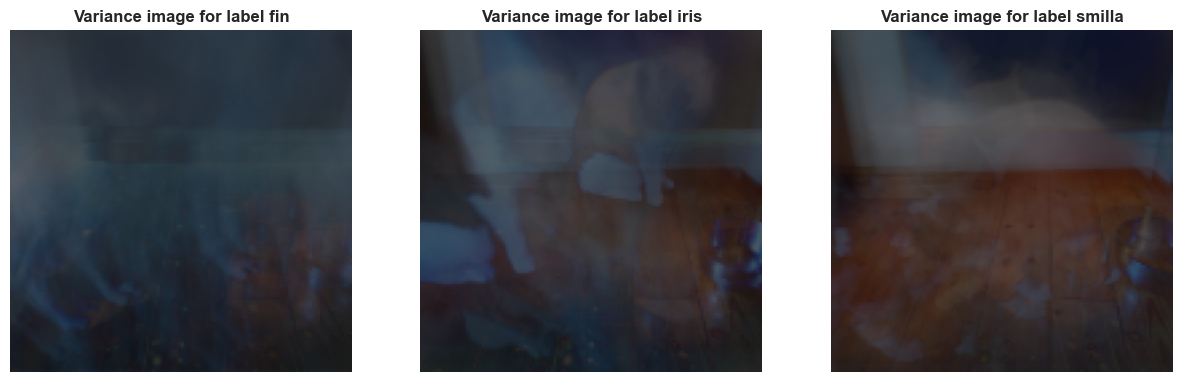

In [16]:
show_means(compound_dict["means"], "Average", LABELS)
show_means(compound_dict["vars"], "Variance", LABELS)

The images seem distinguishable from each other. However, we want to be able to make a recommendation based on an explicit number or graph that will show whether our model architecture is suitable for the given image sets.
First, we look for a baseline that shows the differences between the mean images.

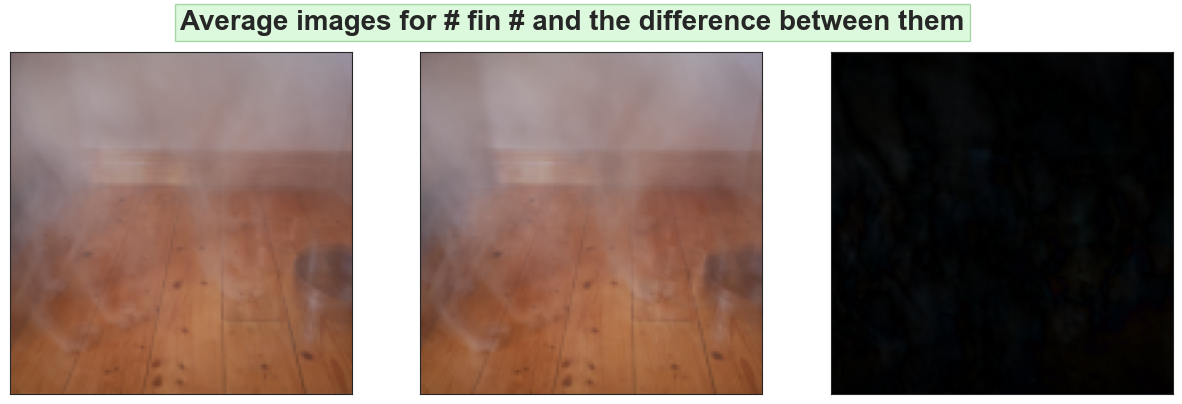

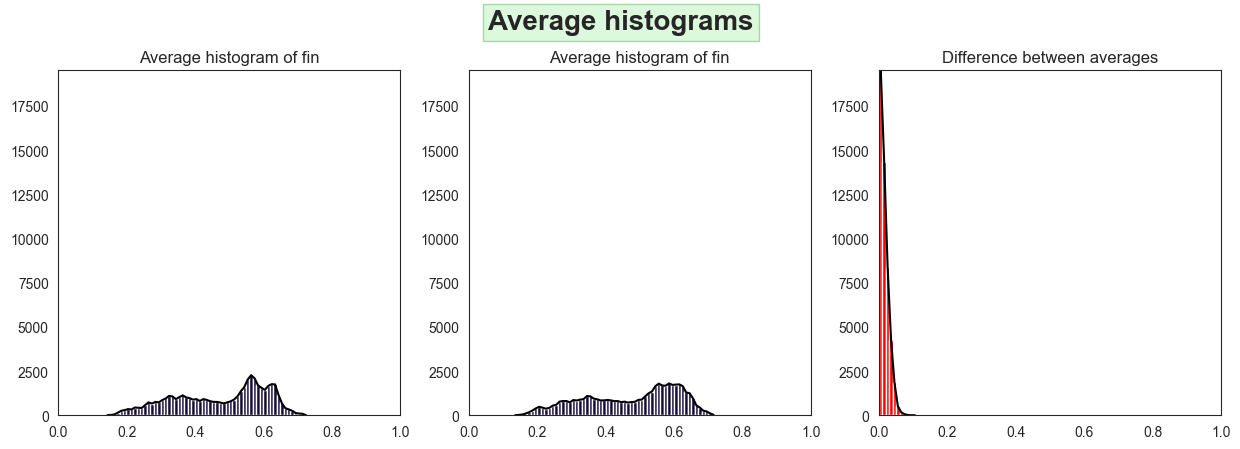

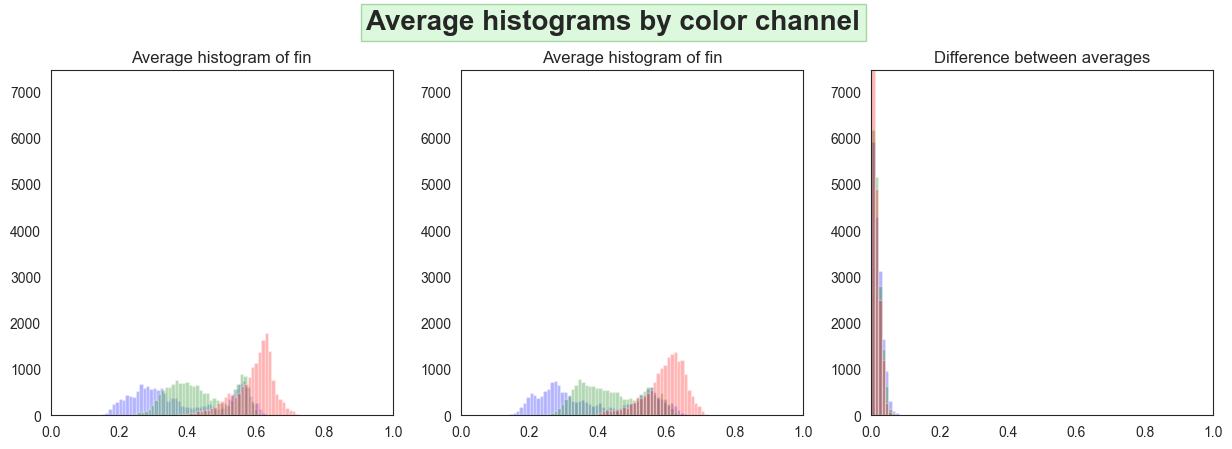

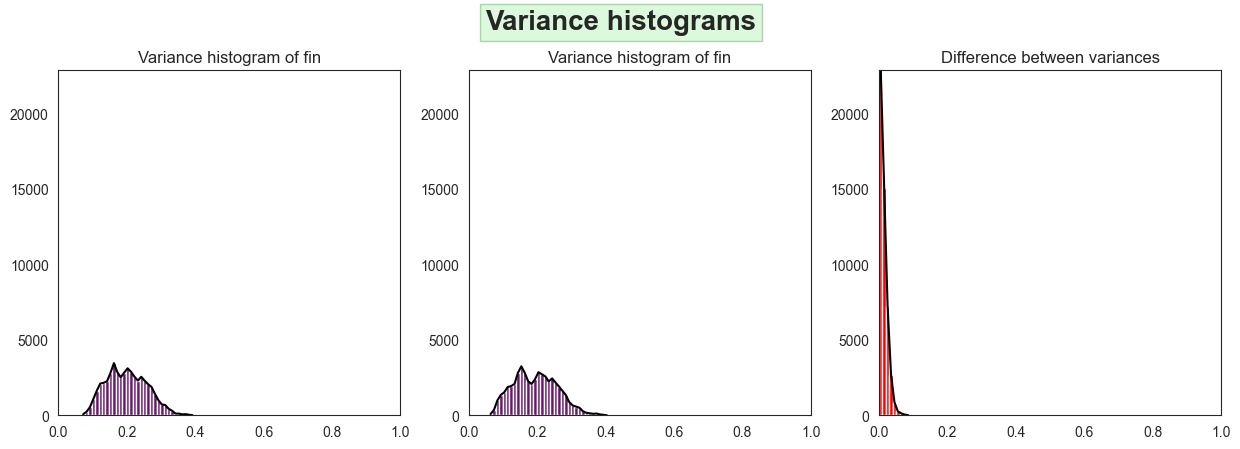

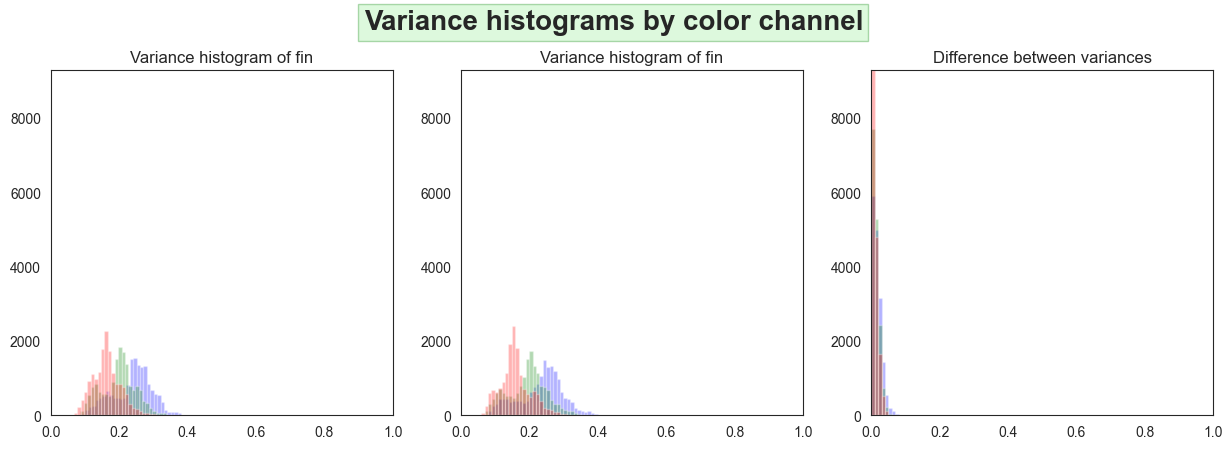

In [17]:
def show_hist(img_1, img_2, graph_color, img_type, labels):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    plt.suptitle(
        f"{img_type.capitalize()} histograms",
        fontproperties=font_top,
        **title_props_box,
    )
    y_lim = 0

    for ax, img, color in zip(
        axes, [img_1, img_2, abs(img_1 - img_2)], [graph_color, graph_color, "red"]
    ):
        data = img.flatten()
        y_val, bin_edges, patches = ax.hist(
            data, bins=np.arange(min(data), max(data) + 0.01, 0.01), color=color
        )
        bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        ax.plot(bin_centers, y_val, "-", c="black")

    y_lim = max([max([i.get_height() for i in ax.patches]) for ax in axes])
    for ax in axes:
        ax.set(xlim=(0, 1), ylim=(0, y_lim))

    axes[0].set_title(f"{img_type.capitalize()} histogram of {labels[0]}")
    axes[1].set_title(f"{img_type.capitalize()} histogram of {labels[1]}")
    axes[2].set_title(f"Difference between {img_type}s")
    plt.subplots_adjust(top=0.8)
    save_str = (
        f"hist_baseline_{img_type}.png"
        if labels[0] == labels[1]
        else f"hist_{img_type}_{labels[0]}_{labels[1]}.png"
    )
    plt.savefig(f"{output_path}/{save_str}", bbox_inches="tight", dpi=150)
    plt.show()

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    plt.suptitle(
        f"{img_type.capitalize()} histograms by color channel",
        fontproperties=font_top,
        **title_props_box,
    )
    y_lim = 0
    for ax, img, color in zip(
        axes, [img_1, img_2, abs(img_1 - img_2)], [graph_color, graph_color, "red"]
    ):
        for ch, col in zip([2, 1, 0], ["b", "g", "r"]):
            data = img[..., ch].flatten()
            y_val, bin_edges, patches = ax.hist(
                data,
                bins=np.arange(min(data), max(data) + 0.01, 0.01),
                alpha=0.3,
                color=col,
            )
    y_lim = max([max([i.get_height() for i in ax.patches]) for ax in axes])
    for ax in axes:
        ax.set(xlim=(0, 1), ylim=(0, y_lim))

    axes[0].set_title(f"{img_type.capitalize()} histogram of {labels[0]}")
    axes[1].set_title(f"{img_type.capitalize()} histogram of {labels[1]}")
    axes[2].set_title(f"Difference between {img_type}s")
    plt.subplots_adjust(top=0.8)
    save_str = (
        f"hist_baseline_{img_type}_rgb.png"
        if labels[0] == labels[1]
        else f"hist_{img_type}_{labels[0]}_{labels[1]}_rgb.png"
    )
    plt.savefig(f"{output_path}/{save_str}", bbox_inches="tight", dpi=150)
    plt.show()


def find_baseline(X, y, labels):

    y = y.reshape(-1, 1, 1)
    bool_mask = np.any(y == labels[0], axis=1).reshape(-1)
    arr = X[bool_mask]

    mid_idx = int(len(arr) // 2)

    arr_1, arr_2 = arr[:mid_idx], arr[mid_idx:]
    mean_1 = np.mean(arr_1, axis=0)
    mean_2 = np.mean(arr_2, axis=0)
    mean_diff = abs(mean_1 - mean_2)
    var_1 = np.std(arr_1, axis=0)
    var_2 = np.std(arr_2, axis=0)

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    plt.suptitle(
        f"Average images for # {labels[0]} # and the difference between them",
        fontproperties=font_top,
        **title_props_box,
    )  # , fontweight='bold')
    for ax, img in zip(axes, [mean_1, mean_2, mean_diff]):
        ax.imshow(img)
        set_ticks(ax)

    plt.savefig(f"{output_path}/baseline_imgs.png", bbox_inches="tight", dpi=150)
    plt.show()

    cmap = plt.colormaps["inferno"]
    colors = cmap(np.linspace(0.1, 0.3, 2))

    # Show average histograms and plot the differences
    show_hist(mean_1, mean_2, colors[0], "average", [labels[0], labels[0]])

    # Show variance histograms and plot the differences
    show_hist(var_1, var_2, colors[1], "variance", [labels[0], labels[0]])

    baseline_vals = {
        "Total means": [np.mean(mean_1), np.mean(mean_2)],
        "Diff mean": np.mean(abs(mean_1 - mean_2)),
        "Total vars": [np.std(var_1), np.std(var_2)],
        "Diff var": np.mean(abs(var_1 - var_2)),
    }
    return baseline_vals


baseline_vals = find_baseline(X_sample, y_sample, LABELS)

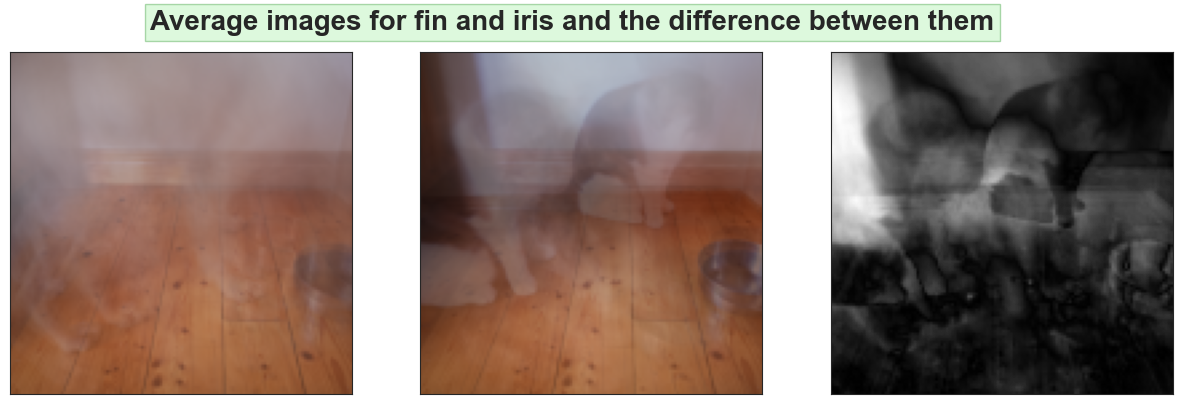

Histogram comparison for the averages


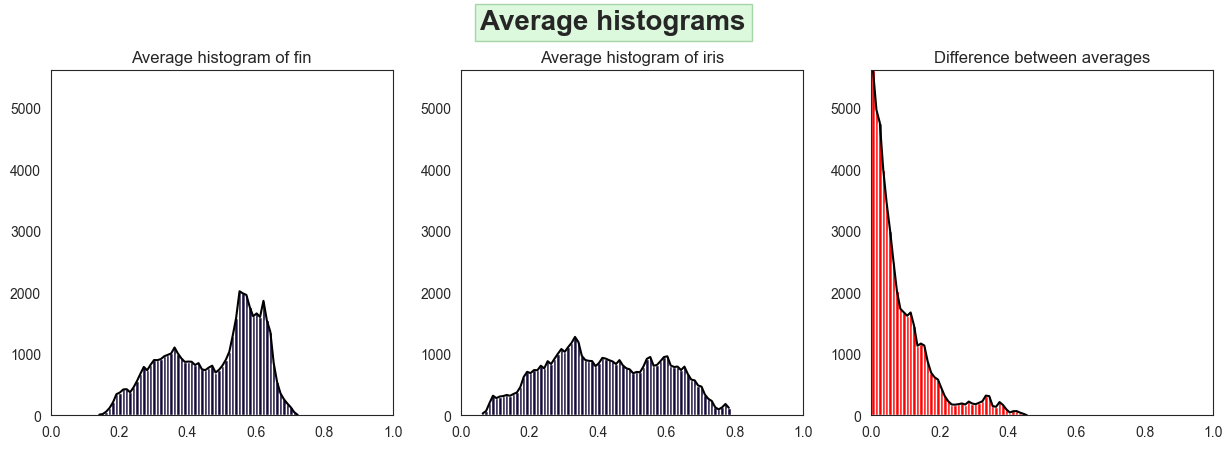

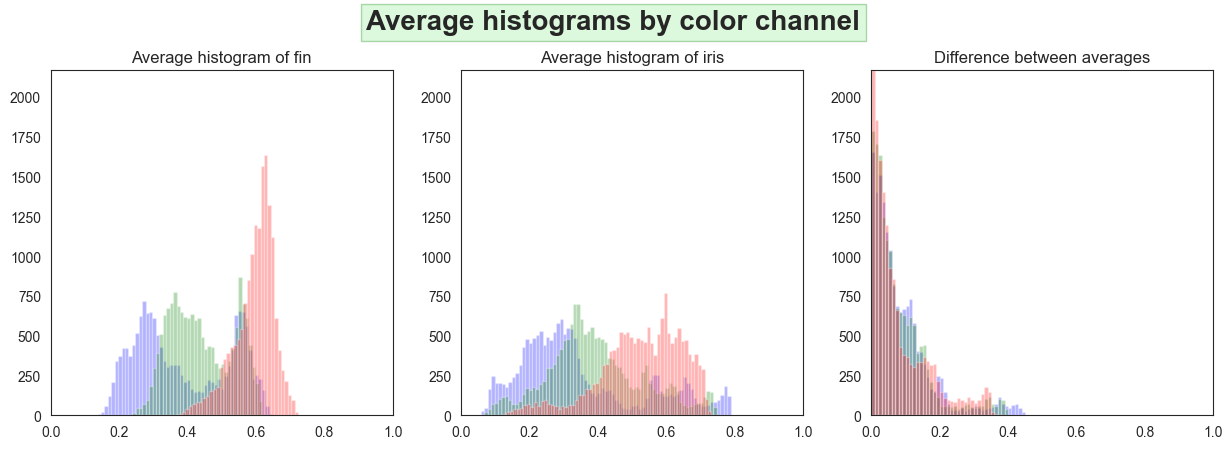

Histogram comparison for the variances


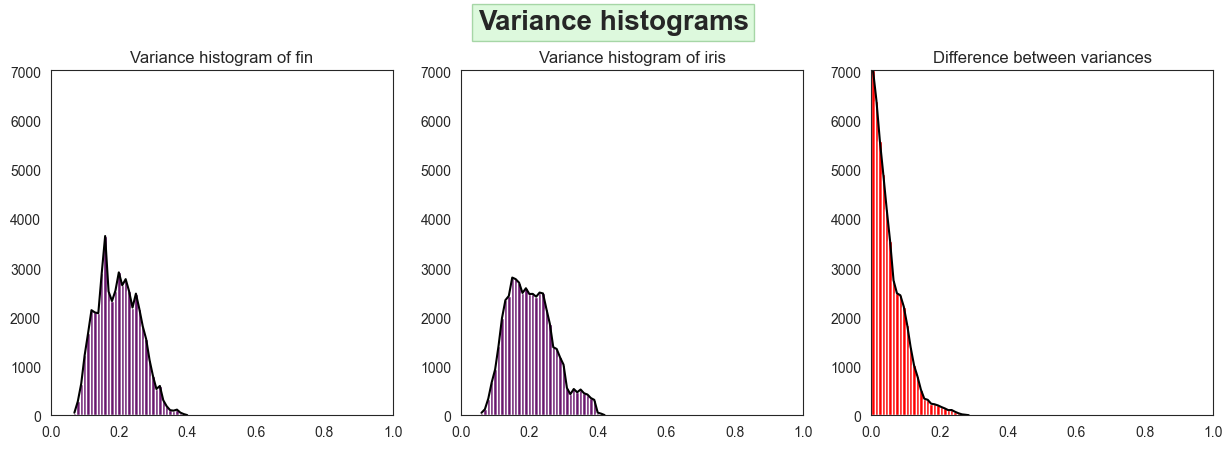

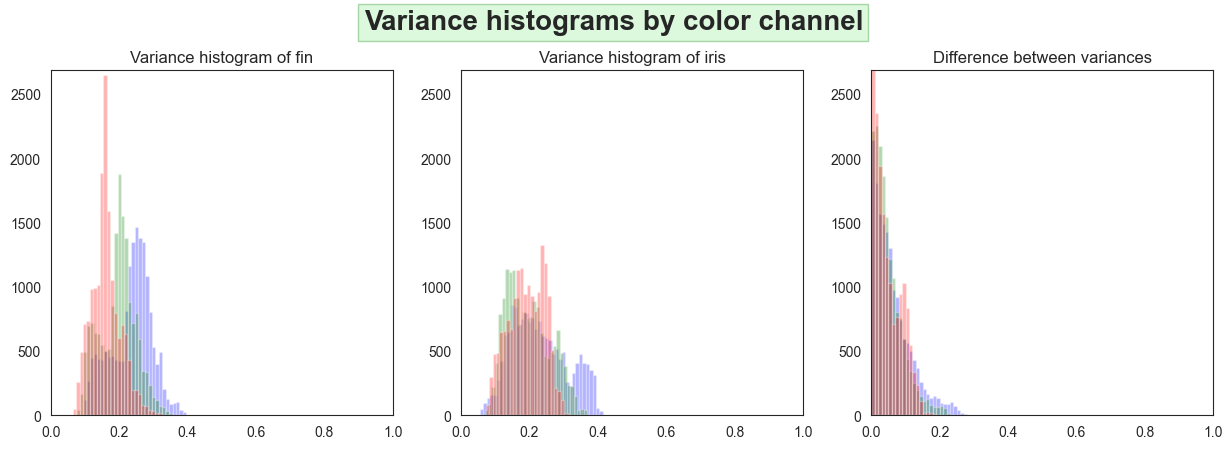

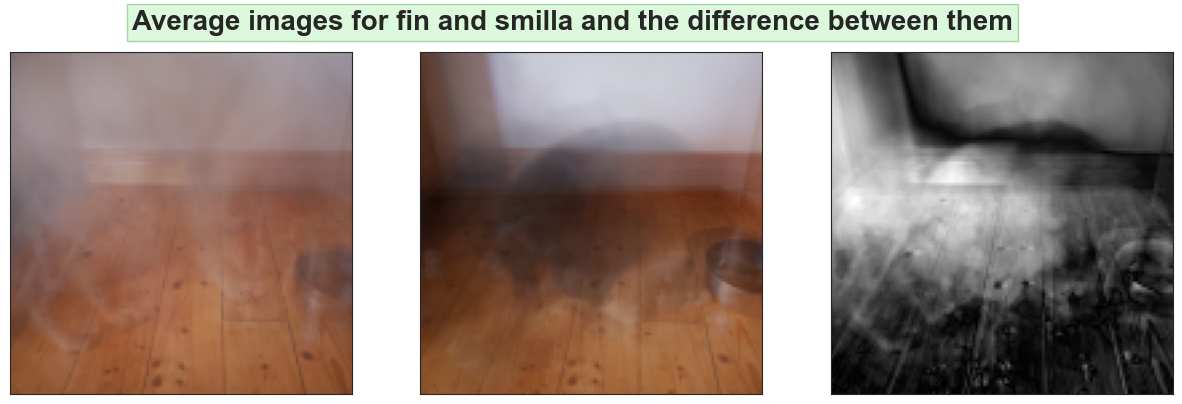

Histogram comparison for the averages


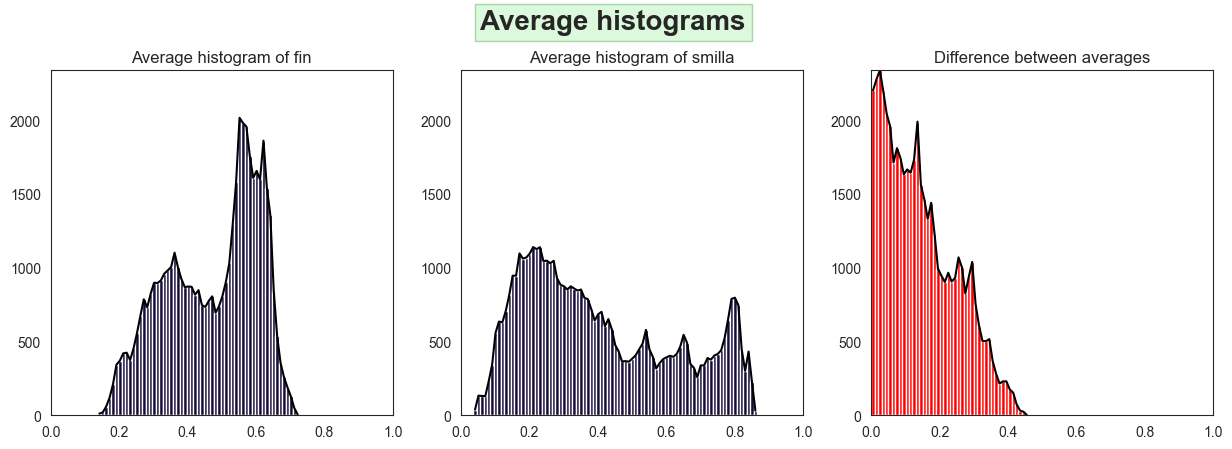

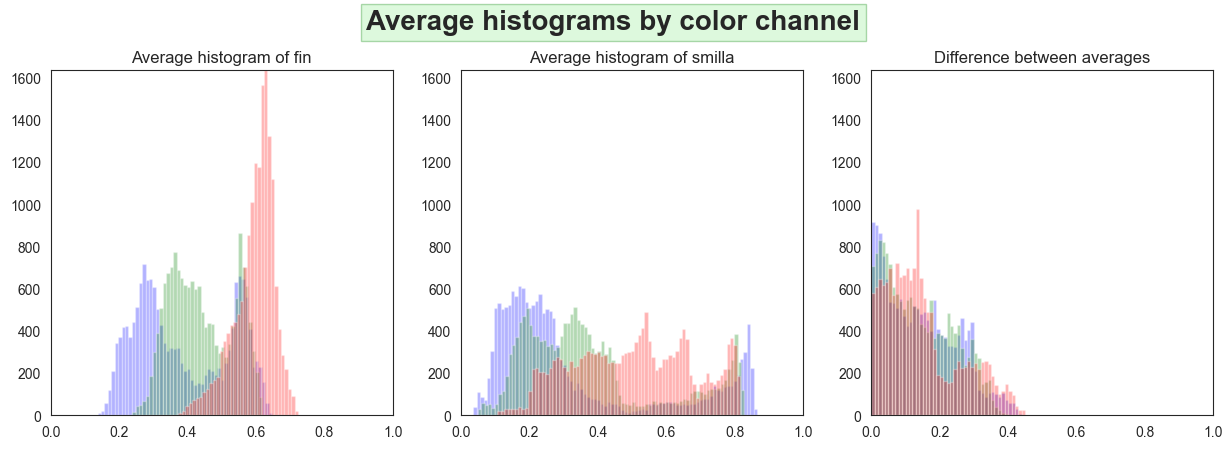

Histogram comparison for the variances


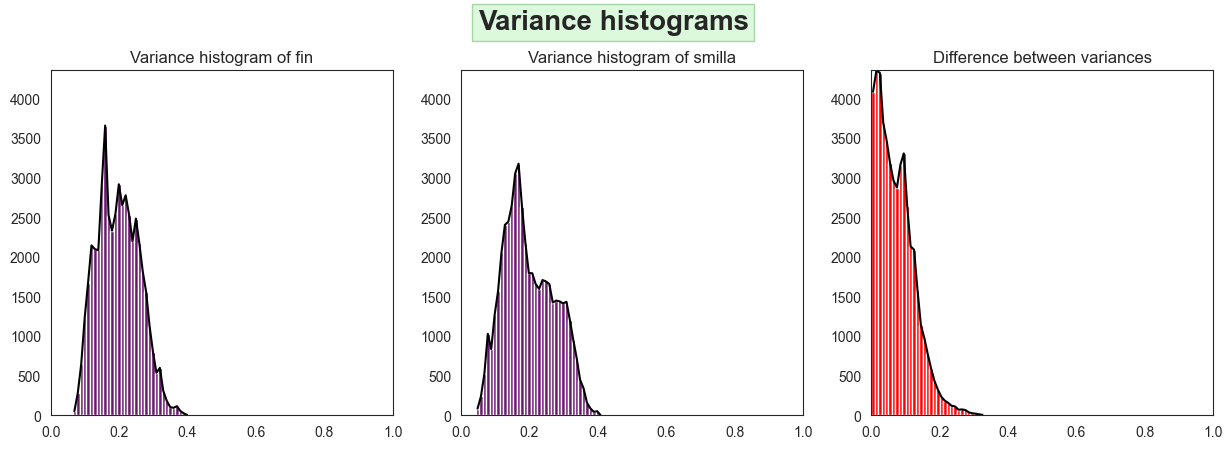

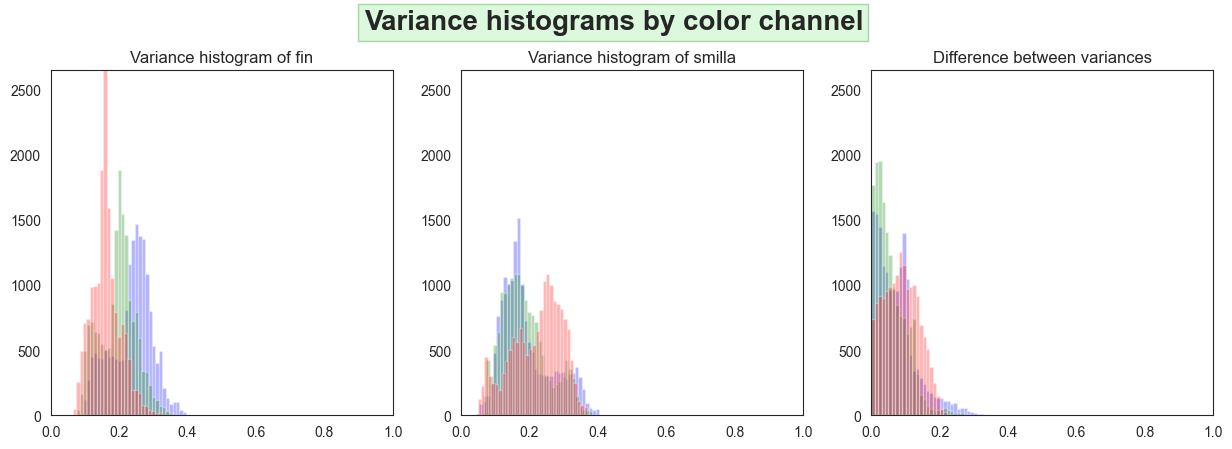

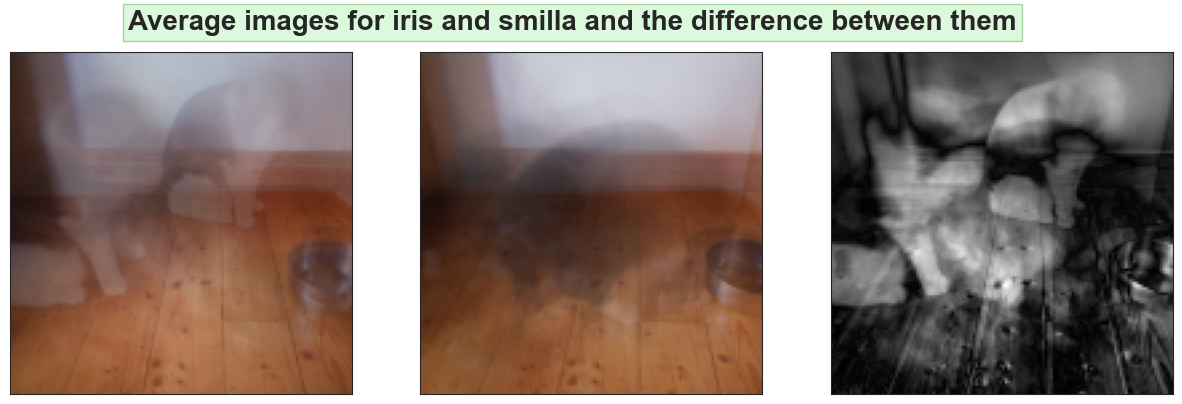

Histogram comparison for the averages


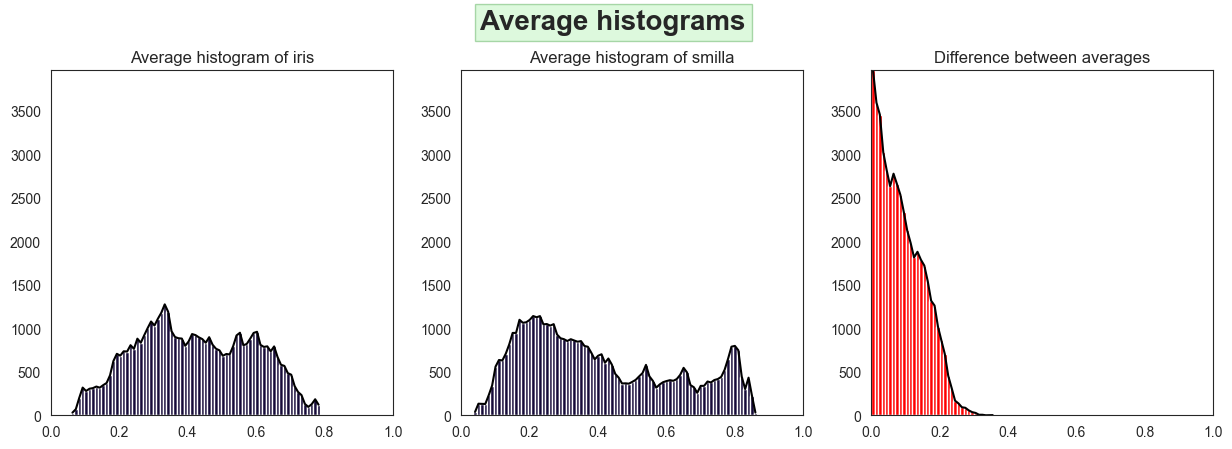

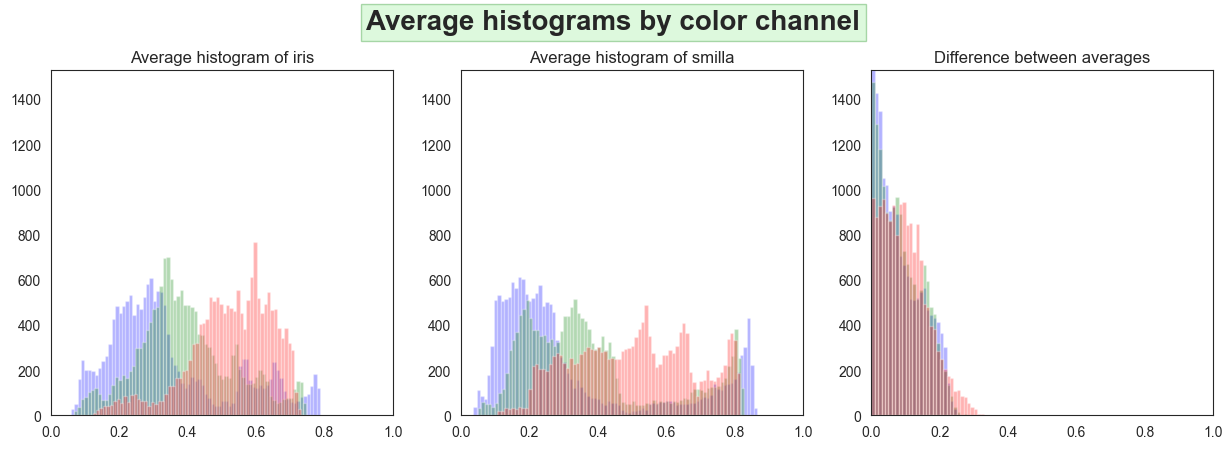

Histogram comparison for the variances


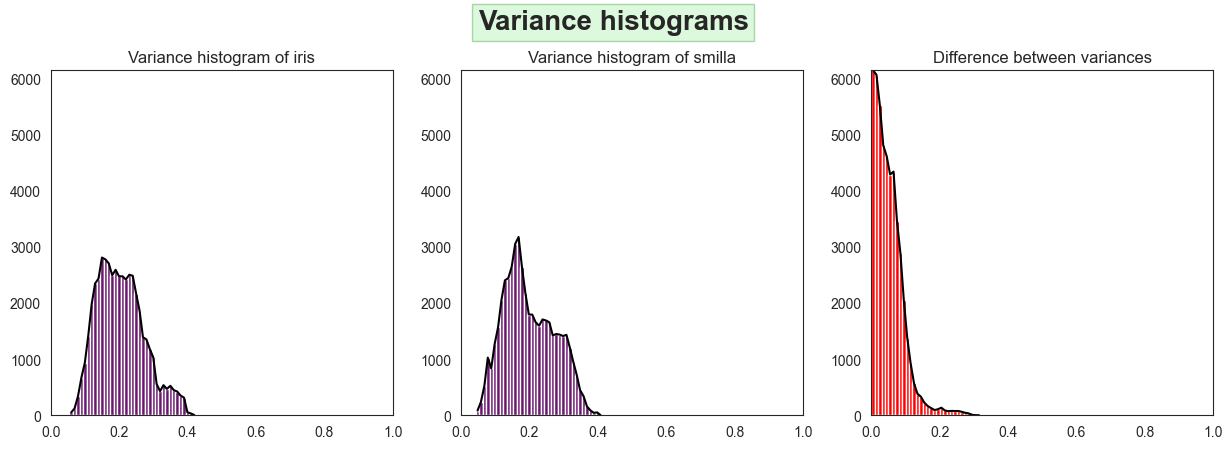

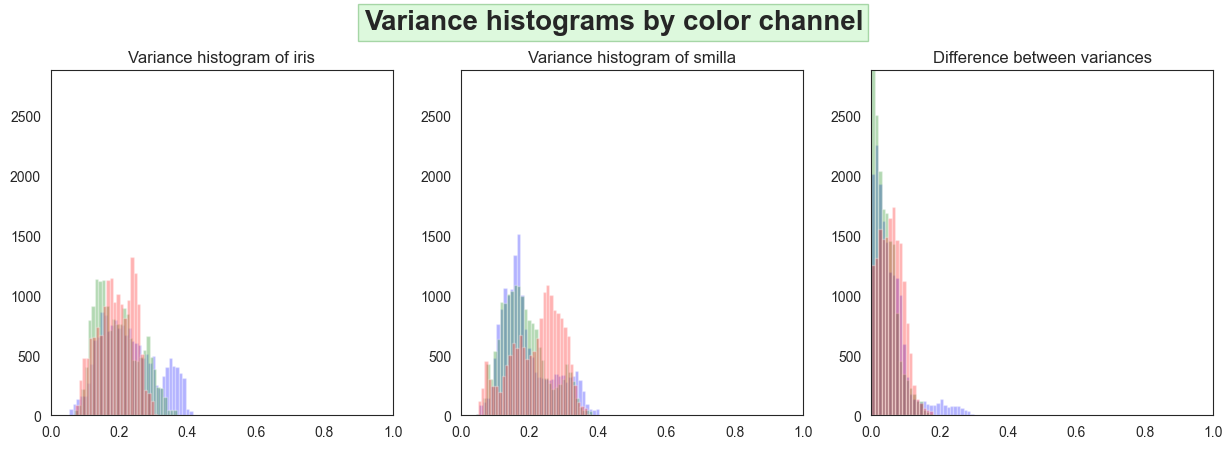

In [18]:
from skimage.color import rgb2gray

# Compare all labels


def compare_labels(X, y, labels, comp_dict):
    comparison_vals = {}
    combos = list(itertools.combinations(labels, 2))

    for combo in combos:

        mean_1 = comp_dict["means"][combo[0]]
        mean_2 = comp_dict["means"][combo[1]]
        var_1 = comp_dict["vars"][combo[0]]
        var_2 = comp_dict["vars"][combo[1]]
        mean_diff = rgb2gray(abs(mean_1 - mean_2))

        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
        plt.suptitle(
            f"Average images for {combo[0]} and {combo[1]} and the difference between them",
            fontproperties=font_top,
            **title_props_box,
        )

        for ax, img in zip(axes, [mean_1, mean_2, mean_diff]):
            ax.imshow(img, cmap="gray")
            set_ticks(ax)
        plt.savefig(
            f"{output_path}/average_imgs_{combo[0]}_{combo[0]}.png",
            bbox_inches="tight",
            dpi=150,
        )
        plt.show()

        cmap = plt.colormaps["inferno"]
        colors = cmap(np.linspace(0.1, 0.3, 2))

        print("Histogram comparison for the averages")
        # Show average histograms and plot the differences
        show_hist(mean_1, mean_2, colors[0], "average", [combo[0], combo[1]])

        print("Histogram comparison for the variances")
        # Show variance histograms and plot the differences
        show_hist(var_1, var_2, colors[1], "variance", [combo[0], combo[1]])

        comparison_vals[f"{combo[0]}&{combo[1]}"] = {
            "Total means": [np.mean(mean_1), np.mean(mean_2)],
            "Diff mean": np.mean(abs(mean_1 - mean_2)),
            "Total vars": [np.std(var_1), np.std(var_2)],
            "Diff var": np.mean(abs(var_1 - var_2)),
        }

    return comparison_vals


comparison_vals = compare_labels(X_sample, y_sample, LABELS, compound_dict)

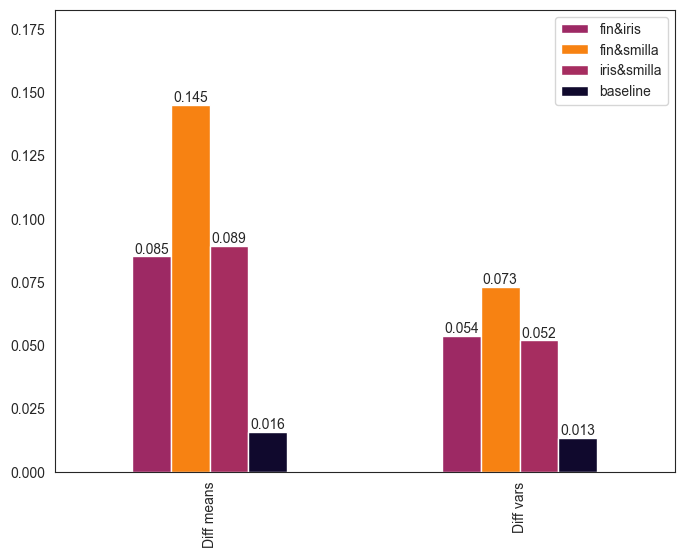

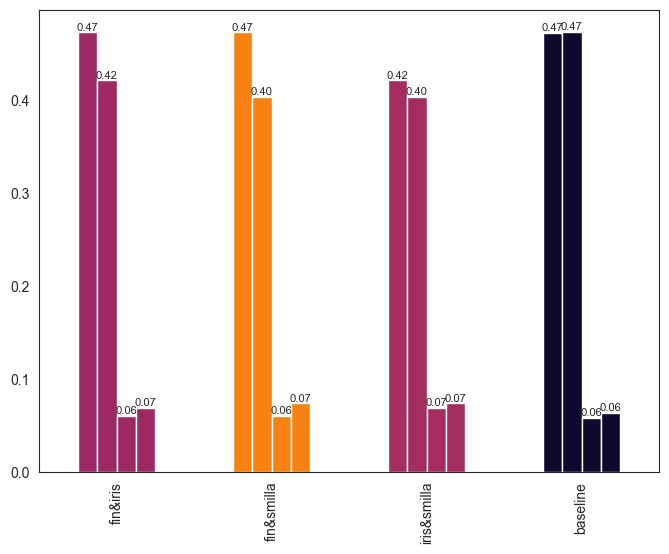

In [19]:
data = comparison_vals
data["baseline"] = baseline_vals

print("")

final_nums = pd.DataFrame(
    {
        "Mean of 1": [v["Total means"][0] for v in data.values()],
        "Mean of 2": [v["Total means"][1] for v in data.values()],
        "Diff means": [v["Diff mean"] for v in data.values()],
        "Var of 1": [v["Total vars"][0] for v in data.values()],
        "Var of 2": [v["Total vars"][1] for v in data.values()],
        "Diff vars": [v["Diff var"] for v in data.values()],
    },
    index=(data.keys()),
)

diff_comp = final_nums[["Diff means", "Diff vars"]]
bar_amount = len(diff_comp.index)
cmap = plt.colormaps["inferno"]
colors = []
# The smaller the number, the darker the color
for num in diff_comp["Diff means"]:
    colors.append(cmap(num * 5))

ax = diff_comp.T.plot.bar(color=[col for col in colors], figsize=(bar_amount * 2, 6))
# Make space for the legend at the top
ylim = (0, ax.get_ylim()[1] * 1.2)
ax.set_ylim(ylim)
for cont in ax.containers:
    ax.bar_label(cont, fmt="%.3f")
plt.savefig(f"{output_path}/final_diff_comp.png")
plt.show()

juxtapos = final_nums[["Mean of 1", "Mean of 2", "Var of 1", "Var of 2"]]
ax = juxtapos.plot.bar(figsize=(bar_amount * 2, 6), legend=False)
for idx, cont in enumerate(ax.containers):
    ax.bar_label(cont, fmt="%.2f", fontsize="8")
for c, patch in enumerate(ax.patches):
    patch.set_facecolor(colors[c % 4])
plt.savefig(f"{output_path}/final_juxtapos.png")
plt.show()